In [1]:
import numpy as np
import pandas as pd
import pretty_midi
import collections
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from IPython import display
import fluidsynth

%matplotlib inline
from matplotlib import pyplot as plt

In [317]:
_datadir = Path('./data/classical')

files = collections.defaultdict(list)
for filepath in _datadir.glob('*.mid'):
    files['file'].append(str(filepath))
    composer = filepath.stem.split('_')[0]
    files['composer'].append(composer)

    pm = pretty_midi.PrettyMIDI(str(filepath))
    files['end_time'].append(pm.get_end_time())


    tempos, probabilities = pm.estimate_tempi()
    assert np.isclose(sum(probabilities), 1)
    tempo_bpm = np.dot(tempos, probabilities) # expected tempo in beats/min
    seconds_per_beat = (1/tempo_bpm)*60
    time_sig_denom = pm.time_signature_changes[0].denominator
    note_dist = seconds_per_beat / (16 / time_sig_denom)
    note_dist *= 2

    files['expected_tempo'].append(tempo_bpm)
    files['sampling_note_duration'].append(note_dist)
    roll = pm.get_piano_roll(fs=1/note_dist)
    files['roll_length'].append(roll.shape[1])

df_meta = pd.DataFrame({ key: np.asarray(val) for key, val in files.items() })
df_meta.to_csv(_metadata_file, index=False)
    
    
df_meta.head()

,file,composer,end_time,expected_tempo,sampling_note_duration,roll_length
0,data/classical/beethoven_opus22_1.mid,beethoven,399.624004,164.101873,0.182813,2185
1,data/classical/schub_d760_4.mid,schub,206.069698,240.133084,0.124931,1642
2,data/classical/mz_330_3.mid,mz,482.101321,189.367179,0.158422,3043
3,data/classical/beethoven_les_adieux_1.mid,beethoven,341.950341,214.732513,0.139709,2447
4,data/classical/burg_spinnerlied.mid,burg,102.871024,277.682898,0.108037,952


# define dataset

In [230]:
class PianoRoll(Dataset):
    
    def __init__(self, df_meta: pd.DataFrame, seq_length: int = 25, 
                 batch_size: int = 20, batch_per_file=None):
        self.df_meta = df_meta.copy()

        self.df_meta['n_batches'] = (self.df_meta['roll_length'] - seq_length )*0.99 // batch_size
        self.df_meta['n_batches'] = self.df_meta['n_batches'].astype(int)
        file_idx_ends = []
        n_batches = self.df_meta['n_batches'].values
        file_idx_ends = [n_batches[0]*batch_size - 1]
        for batches_in_file in n_batches[1:]:
            file_idx_ends.append(batches_in_file*batch_size + file_idx_ends[-1] )

        self.df_meta['file_idx_ends'] = file_idx_ends

        
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.batch_per_file = batch_per_file

        if self.batch_per_file is not None:
            self.idx_per_file = self.batch_size*self.batch_per_file
        else:
            self.idx_per_file = None
        
        self.roll_cache = {}
        
    def __len__(self):
        if self.batch_per_file is None:
            return int(self.df_meta['n_batches'].sum()*self.batch_size)
        else:
            return self.df_meta.shape[0]*self.idx_per_file
    
    def __getitem__(self, idx):
        if self.batch_per_file is None:
            file_idx_ends = self.df_meta['file_idx_ends'].values
            for i in range(len(file_idx_ends)):
                if idx <= file_idx_ends[i]:
                    file_idx = i
                    break
            if file_idx == 0:
                idx_start = 0
            else:
                idx_start = file_idx_ends[file_idx - 1]
            window_idx = int(idx - idx_start)
        else:
            file_idx = idx // self.idx_per_file
            window_idx = idx % self.idx_per_file
        
        
        seq, label = self.get_rolls(file_idx, window_idx)
        
        seq = torch.from_numpy(seq).float()
        label = torch.from_numpy(label).float()
        return seq, label
    
    def midi_to_pianoroll(self, file, sample_dist=0.02):
        pm = pretty_midi.PrettyMIDI(file)
        
        sampling_rate = 1/sample_dist
        piano_roll = pm.get_piano_roll(fs=sampling_rate)
        return piano_roll
    
    def get_rolls(self, file_idx, window_idx):
        file_path = self.df_meta.iloc[file_idx]['file']
        
        if file_idx in self.roll_cache:
            roll = self.roll_cache[file_idx]
        else:
            note_dist = self.df_meta.iloc[file_idx]['sampling_note_duration']
            roll = self.midi_to_pianoroll(file_path, sample_dist=note_dist)
            self.roll_cache[file_idx] = roll
            
        roll[roll != 0] = 1
        roll = roll.T
        roll_window = roll[window_idx:window_idx+self.seq_length+1, :]
        
        seq = roll_window[:-1]
        # seq[seq == 0] = -1
        label = roll_window[-1]
        return seq, label

In [232]:
class PianoRoll(Dataset):
    
    def __init__(self, df_meta: pd.DataFrame, seq_length: int = 25, max_windows=None):
        self.df_meta = df_meta.copy()

        
        n_windows = self.df_meta['roll_length'].values - seq_length - 1
        if max_windows is not None:
            n_windows[n_windows > max_windows] = max_windows
            
        self.df_meta['n_windows'] = n_windows
        self.df_meta['n_windows'] = self.df_meta['n_windows'].astype(int)
        
        file_idx_ends = []
        n_windows = self.df_meta['n_windows'].values
        file_idx_ends = [n_windows[0] - 1]
        for windows_in_file in n_windows[1:]:
            file_idx_ends.append(windows_in_file + file_idx_ends[-1] )

        self.df_meta['file_idx_ends'] = file_idx_ends
        self.seq_length = seq_length
        
        self.roll_cache = {}
        
    def __len__(self):
        return self.df_meta['n_windows'].sum()
    
    def __getitem__(self, idx):
        file_idx = self.get_file_idx(idx)
        window_idx = self.get_window_idx(idx)
        
        seq, label = self.get_rolls(file_idx, window_idx)
        
        seq = torch.from_numpy(seq).float()
        label = torch.from_numpy(label).float()
        return seq, label
    
    def get_file_idx(self, idx):
        file_idx = None
        file_idx_ends = self.df_meta['file_idx_ends'].values
        for i in range(len(file_idx_ends)):
            if idx <= file_idx_ends[i]:
                file_idx = i
                break
        if file_idx is None:
            raise ValueError(f'file_idx could not be found for {idx=}')
        return file_idx
    
    def get_window_idx(self, idx):
        file_idx = self.get_file_idx(idx)
        file_idx_ends = self.df_meta['file_idx_ends'].values
        if file_idx == 0:
            idx_start = 0
        else:
            idx_start = file_idx_ends[file_idx - 1]
            
        window_idx = int(idx - idx_start)
        return window_idx
    
    def midi_to_pianoroll(self, file, sample_dist=0.02):
        pm = pretty_midi.PrettyMIDI(file)
        
        sampling_rate = 1/sample_dist
        piano_roll = pm.get_piano_roll(fs=sampling_rate)
        return piano_roll
    
    def get_rolls(self, file_idx, window_idx):
        file_path = self.df_meta.iloc[file_idx]['file']
        
        if file_idx in self.roll_cache:
            roll = self.roll_cache[file_idx]
        else:
            note_dist = self.df_meta.iloc[file_idx]['sampling_note_duration']
            roll = self.midi_to_pianoroll(file_path, sample_dist=note_dist)
            self.roll_cache[file_idx] = roll
            
        roll[roll != 0] = 1
        roll = roll.T
        roll_window = roll[window_idx:window_idx+self.seq_length+1, :]
        
        seq = roll_window[:-1]
        # seq[seq == 0] = -1
        label = roll_window[-1]
        return seq, label

# define model

In [3]:
class PianoRollLSTM(nn.Module):
    def __init__(self, hidden_size=64):
        super(PianoRollLSTM, self).__init__()
        
        input_size=128
        self.hidden_size = hidden_size
            
        self.lstm = nn.LSTM(input_size=input_size, batch_first=True, num_layers=1, hidden_size=hidden_size)
        
        self.norm = nn.BatchNorm1d(num_features=hidden_size)
        
        self.pitch_layer = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # xnorm = self.norm(x)
        output, (h_n, c_n) = self.lstm(x)
        linear_input = output[:, -1, :]
        normed_linear_input = self.norm(linear_input)
        left_output = self.pitch_layer(normed_linear_input)
        return left_output

# get a baseline

In [281]:
dset_train.df_meta

,file,composer,end_time,expected_tempo,sampling_note_duration,roll_length,n_windows,file_idx_ends
111,/home/ian/projects/music-rnn/data/classical/ch...,chpn,91.375454,172.837155,0.173574,526,505,504


In [319]:
dset_train.df_meta

,file,composer,end_time,expected_tempo,sampling_note_duration,roll_length,n_windows,file_idx_ends
111,/home/ian/projects/music-rnn/data/classical/ch...,chpn,91.375454,172.837155,0.173574,526,495,494


In [320]:
torch.manual_seed(0)
# set filepaths
print('i am running!', flush=True)
_reporoot = Path('/home/ian/projects/music-rnn')
# _reporoot = Path('/net/dali/home/mscbio/icd3/music-rnn')
_datadir = _reporoot / 'data' / 'classical'
_metadata_file = _datadir / 'metadata.csv'
output_dir = Path('./')
if not output_dir.exists():
    output_dir.mkdir()
metrics_file = output_dir / 'metrics.csv'

# fix filepaths in metadata according to given filepaths
df_meta = pd.read_csv(_metadata_file)
def process_path(row, _datadir=_datadir):
    fp = Path(row['file'])
    new_fp = _datadir / fp.name
    return str(new_fp)
df_meta['file'] = df_meta.apply(process_path, axis=1)

seq_length = 30
learning_rate = 3e-4
batch_size = 8
num_workers = 0
n_iters = 494*30
out_interval = 2000
hidden_size = 60

df_chpn = df_meta[df_meta['composer'] == 'chpn']
rng = np.random.default_rng(12345)
idx = np.arange(df_chpn.shape[0])
n_train = int(0.8*idx.shape[0])
train_idx = rng.choice(idx, size=n_train, replace=False)
test_idx = idx[~np.in1d(idx, train_idx)]
df_train = df_chpn.iloc[train_idx]
df_test = df_chpn.iloc[test_idx]

dset_train = PianoRoll(df_meta=df_train.iloc[0:1], 
                    seq_length=seq_length)


dset_test = PianoRoll(df_meta=df_test, 
                    max_windows=40)


train_dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
test_dataloader = DataLoader(dset_test, batch_size=batch_size, shuffle=False, num_workers=0)

model = PianoRollMod(hidden_size=hidden_size)
model.pitch_layer[0].bias = nn.Parameter(model.pitch_layer[0].bias - 0.24)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

metrics = collections.defaultdict(list)

iter_idx = -1
train_iterator = iter(train_dataloader)

train_losses = []

while iter_idx < n_iters:
    iter_idx += 1
    # print(f'iter_idx = {iter_idx}', flush=True)

    try:
        features, labels = next(train_iterator)
    except StopIteration:
        train_iterator = iter(train_dataloader)
        features, labels = next(train_iterator)
        
    # features = torch.zeros(features.shape)


    # compute prediction and loss
    # pred = model(features)[0, :, :]
    pred = model(features)
    loss = loss_fn(pred, labels)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())


    # compute metrics every 10 iterations
    if iter_idx % out_interval == 0:

        metrics['iter'].append(iter_idx)

        # compute train loss
        train_loss = np.mean(np.asarray(train_losses))
        metrics['train_loss'].append(train_loss)
        train_losses = []


        # test loop
        test_loss_fn = nn.BCELoss()
        test_loss = 0
        frac_notes_correct = 0
        frac_frames_correct = 0
        num_batches = len(test_dataloader)
        with torch.no_grad():
            for features, labels in test_dataloader:
                # pred = model(features)[0, :, :]
                pred = model(features)
                test_loss += test_loss_fn(pred, labels).item()

                notes = (pred > 0.5).type(torch.float)
                equal = torch.eq(notes, labels)
                frac_notes_correct += torch.mean(torch.sum(equal, axis=1) / 128)
                frac_frames_correct += torch.sum(torch.all(equal, axis=1)) / batch_size

        frac_notes_correct /= num_batches
        frac_frames_correct = frac_frames_correct / num_batches
        test_loss /= num_batches

        metrics['test_loss'].append(test_loss)
        metrics['frac_notes_correct'].append(frac_notes_correct)
        metrics['frac_frames_correct'].append(frac_frames_correct)

        # save metrics
        df_metrics = pd.DataFrame({ key: np.asarray(val) for key, val in metrics.items() })
        # df_metrics.to_csv(metrics_file)

        print(f'{iter_idx=}')

i am running!
iter_idx=0
iter_idx=2000
iter_idx=4000
iter_idx=6000
iter_idx=8000
iter_idx=10000
iter_idx=12000
iter_idx=14000


# viewing model model outputs

In [321]:
df_metrics

,iter,train_loss,test_loss,frac_notes_correct,frac_frames_correct
0,0,0.623499,0.616800,0.700000,0.000
1,2000,0.150621,0.108236,0.974219,0.025
2,4000,0.037855,0.127540,0.971953,0.020
3,6000,0.028306,0.146799,0.970039,0.015
4,8000,0.022353,0.165339,0.968281,0.005
5,10000,0.018314,0.184389,0.966211,0.000
6,12000,0.015288,0.202516,0.965039,0.000
7,14000,0.013090,0.219467,0.964844,0.000


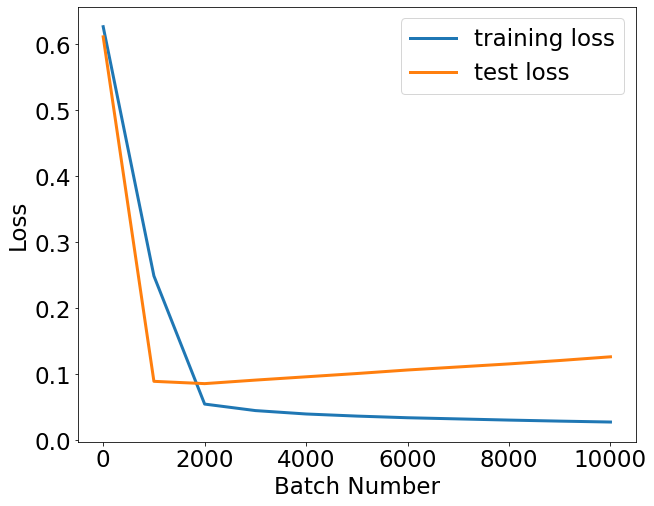

In [305]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["font.size"] = 23

plt.plot(df_metrics['iter'], df_metrics['train_loss'], label='training loss', linewidth=3)
plt.plot(df_metrics['iter'], df_metrics['test_loss'], label='test loss', linewidth=3)

plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

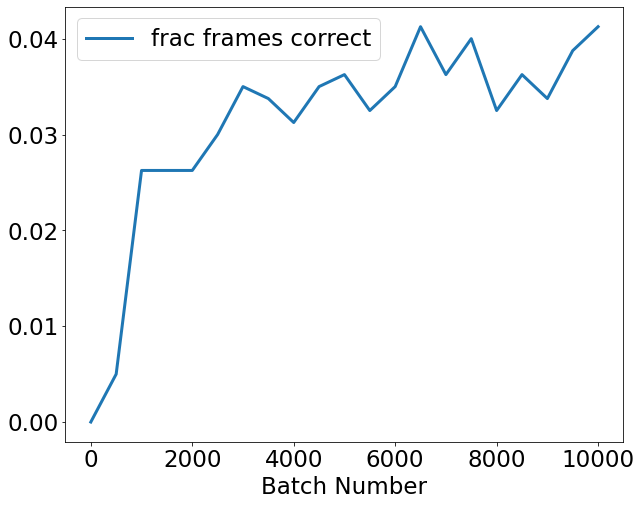

In [75]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["font.size"] = 23

# plt.plot(df_metrics['iter'], df_metrics['frac_notes_correct'], label='frac pitches correct', linewidth=3)
plt.plot(df_metrics['iter'], df_metrics['frac_frames_correct'], label='frac frames correct', linewidth=3)

plt.xlabel('Batch Number')
plt.ylabel('')
plt.legend()
plt.show()

In [11]:
from preprocess.process_output import pianoRoll_to_midi
_SAMPLING_RATE = 16000

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform= pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    # waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform, rate=_SAMPLING_RATE)

In [323]:
next_frames = []
model.eval()
start_idx = 0
seq_len = 30*3
sequence, label = dset_test[start_idx]
timestep = dset_test.df_meta.iloc[0]['sampling_note_duration']

primer = pd.DataFrame(np.asarray(sequence).astype(int))
display.display(
    display_audio(pianoRoll_to_midi(primer, timestep=timestep))
)

with torch.no_grad():
    for idx in range(seq_len):
        # sequence, label = dset_test[start_idx + idx]
        pred = model(sequence.view(1, *sequence.shape))
        next_frame = (pred > 0.5).float()
        next_frames.append(next_frame)
        extended_sequence = torch.cat([sequence, next_frame], dim=0)
        sequence = extended_sequence[1:]

out = torch.cat(next_frames,dim=0)
out = np.asarray(out).astype(int)
df_proll = pd.DataFrame(out)
timestep = dset_test.df_meta.iloc[0]['sampling_note_duration']

midi = pianoRoll_to_midi(df_proll, timestep=timestep)
display_audio(midi)

In [309]:
out.shape

(3000, 128)

# simple data

In [85]:
_datadir = Path('./data/scales')
_metadata_file = _datadir / 'metadata.csv'

if not _metadata_file.exists():
    files = collections.defaultdict(list)
    for filepath in _datadir.glob('*.mid'):
        files['file'].append(str(filepath))
        composer = filepath.stem.split('_')[0]
        # files['composer'].append(composer)

        pm = pretty_midi.PrettyMIDI(str(filepath))
        files['end_time'].append(pm.get_end_time())
        
        
        tempos, probabilities = pm.estimate_tempi()
        assert np.isclose(sum(probabilities), 1)
        tempo_bpm = np.dot(tempos, probabilities) # expected tempo in beats/min
        seconds_per_beat = (1/tempo_bpm)*60
        time_sig_denom = pm.time_signature_changes[0].denominator
        note_dist = seconds_per_beat / (16 / time_sig_denom)
        
        files['expected_tempo'].append(tempo_bpm)
        files['16th_note_duration'].append(note_dist)
        roll = pm.get_piano_roll(fs=1/1)
        files['roll_length'].append(roll.shape[1])

    df_meta = pd.DataFrame({ key: np.asarray(val) for key, val in files.items() })
    df_meta.to_csv(_metadata_file, index=False)
else:
    df_meta = pd.read_csv(_metadata_file)
    
    
df_meta.head()

,file,end_time,expected_tempo,16th_note_duration,roll_length
0,data/scales/c_scale_down.mid,22.0,60.0,0.25,22
1,data/scales/c_scale_updown.mid,43.0,60.0,0.25,43
2,data/scales/c_scale_up.mid,22.0,60.0,0.25,22


In [217]:
class PianoRollMod(nn.Module):
    def __init__(self, hidden_size=64):
        super(PianoRollMod, self).__init__()
        
        input_size=128
        self.hidden_size = hidden_size
            
        self.lstm = nn.LSTM(input_size=input_size, batch_first=True, num_layers=1, hidden_size=hidden_size)
        
        self.norm = nn.BatchNorm1d(num_features=2*hidden_size)
        
        self.pitch_layer = nn.Sequential(
            nn.Linear(hidden_size*2, input_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # xnorm = self.norm(x)
        output, (h_n, c_n) = self.lstm(x)
        # output, _ = self.lstm(x)
        linear_input = torch.concat([output[:, 0, :], output[:, -1, :]], axis=1)
        normed_linear_input = self.norm(linear_input)
        left_output = self.pitch_layer(normed_linear_input)
        return left_output

In [191]:
seq_length = 12
learning_rate = 3e-4
batch_size = 8
num_workers = 0
n_iters = 30*50
out_interval = 100
hidden_size = 60

_datadir = Path('./data/scales')
_metadata_file = _datadir / 'metadata.csv'
df_meta = pd.read_csv(_metadata_file)

df_train = df_meta.iloc[1:2].copy()
df_test = df_meta.iloc[[0, 2]].copy()

dset_train = PianoRoll(df_meta=df_train, 
                    seq_length=seq_length)


dset_test = PianoRoll(df_meta=df_test, 
                    seq_length=seq_length,
                    max_windows=20)


train_dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dset_test, batch_size=batch_size, shuffle=False, num_workers=0)

model = PianoRollMod(hidden_size=hidden_size)
model.pitch_layer[0].bias = nn.Parameter(model.pitch_layer[0].bias - 0.24)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

metrics = collections.defaultdict(list)

iter_idx = -1
train_iterator = iter(train_dataloader)

train_losses = []

while iter_idx < n_iters:
    iter_idx += 1
    # print(f'iter_idx = {iter_idx}', flush=True)

    try:
        features, labels = next(train_iterator)
    except StopIteration:
        train_iterator = iter(train_dataloader)
        features, labels = next(train_iterator)
        
    # features = torch.zeros(features.shape)


    # compute prediction and loss
    # pred = model(features)[0, :, :]
    pred = model(features)
    loss = loss_fn(pred, labels)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())


    # compute metrics every 10 iterations
    if iter_idx % out_interval == 0:

        metrics['iter'].append(iter_idx)

        # compute train loss
        train_loss = np.mean(np.asarray(train_losses))
        metrics['train_loss'].append(train_loss)
        train_losses = []


        # test loop
        test_loss_fn = nn.BCELoss()
        test_loss = 0
        frac_notes_correct = 0
        frac_frames_correct = 0
        num_batches = len(test_dataloader)
        with torch.no_grad():
            for features, labels in test_dataloader:
                # pred = model(features)[0, :, :]
                pred = model(features)
                test_loss += test_loss_fn(pred, labels).item()

                notes = (pred > 0.5).type(torch.float)
                equal = torch.eq(notes, labels)
                frac_notes_correct += torch.mean(torch.sum(equal, axis=1) / 128)
                frac_frames_correct += torch.sum(torch.all(equal, axis=1)) / batch_size

        frac_notes_correct /= num_batches
        frac_frames_correct = frac_frames_correct / num_batches
        test_loss /= num_batches

        metrics['test_loss'].append(test_loss)
        metrics['frac_notes_correct'].append(frac_notes_correct)
        metrics['frac_frames_correct'].append(frac_frames_correct)

        # save metrics
        df_metrics = pd.DataFrame({ key: np.asarray(val) for key, val in metrics.items() })
        # df_metrics.to_csv(metrics_file)

        print(f'{iter_idx=}')

iter_idx=0
iter_idx=100
iter_idx=200
iter_idx=300
iter_idx=400
iter_idx=500
iter_idx=600
iter_idx=700
iter_idx=800
iter_idx=900
iter_idx=1000
iter_idx=1100
iter_idx=1200
iter_idx=1300
iter_idx=1400
iter_idx=1500


In [192]:
df_metrics

,iter,train_loss,test_loss,frac_notes_correct,frac_frames_correct
0,0,0.619832,0.617372,0.678277,0.000000
1,100,0.576790,0.571341,0.819770,0.000000
2,200,0.501256,0.457362,0.924045,0.166667
3,300,0.333901,0.273784,0.971029,0.458333
4,400,0.171712,0.153275,0.988932,0.458333
5,500,0.087402,0.096035,0.992839,0.458333
6,600,0.049744,0.069185,0.993164,0.458333
7,700,0.031665,0.053947,0.995768,0.458333
8,800,0.021798,0.045825,0.995768,0.458333
9,900,0.015980,0.040433,0.996419,0.458333


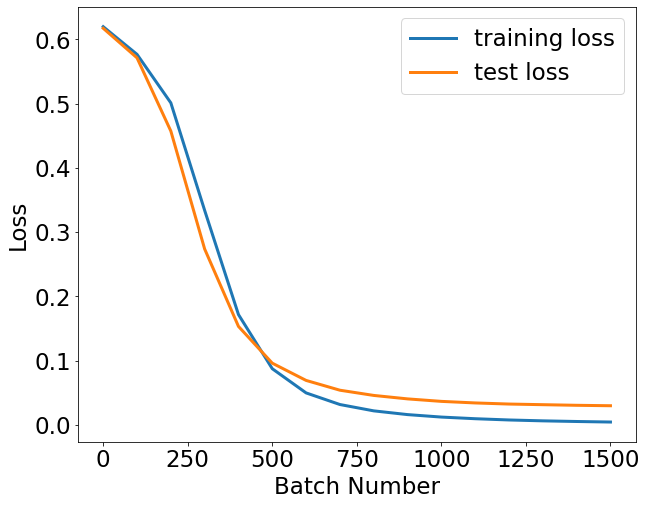

In [193]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["font.size"] = 23

plt.plot(df_metrics['iter'], df_metrics['train_loss'], label='training loss', linewidth=3)
plt.plot(df_metrics['iter'], df_metrics['test_loss'], label='test loss', linewidth=3)

plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [173]:
file = dset_train.df_meta.iloc[0]['file']
midi = pretty_midi.PrettyMIDI(file)
display_audio(midi)

In [196]:
dset_train.df_meta

,file,end_time,expected_tempo,16th_note_duration,roll_length,n_windows,file_idx_ends
1,data/scales/c_scale_updown.mid,43.0,60.0,0.25,43,32,31


In [200]:
next_frames = []
model.eval()
start_idx = 28
seq_len = 4*14
sequence, label = dset_train[start_idx]
timestep = dset_train.df_meta.iloc[0]['16th_note_duration']

primer = pd.DataFrame(np.asarray(sequence).astype(int))
display.display(
    display_audio(pianoRoll_to_midi(primer, timestep=timestep))
)

with torch.no_grad():
    for idx in range(seq_len):
        # sequence, label = dset_test[start_idx + idx]
        pred = model(sequence.view(1, *sequence.shape))
        next_frame = (pred > 0.5).float()
        next_frames.append(next_frame)
        extended_sequence = torch.cat([sequence, next_frame], dim=0)
        sequence = extended_sequence[1:]

out = torch.cat(next_frames,dim=0)
out = np.asarray(out).astype(int)
df_proll = pd.DataFrame(out)
timestep = dset_train.df_meta.iloc[0]['16th_note_duration']

midi = pianoRoll_to_midi(df_proll, timestep=timestep)
display_audio(midi)